# Decision tree by Gender

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [2]:
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')
df.head()

,Event,Conf_Rank,Time,Name,School,Standard,Date,Gender,Division,Season,SeasonYear,Time_Adj,Time_Sec,Div_Rank,NCAA_Rank,ID,Power_Tot,Power,Record,Points
0,50 Freestyle SCY Male,-1,21.22,Ben Beldner,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.220000,21.22,-1,-1,394588,22.71,20.52,17.63,573.483330
1,50 Freestyle SCY Male,-1,20.87,Justin Meyn,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:20.870000,20.87,-1,-1,471360,10.06,20.80,17.63,602.822689
2,50 Freestyle SCY Male,-1,21.31,Joshua Franco,New Jersey Institute of Technology,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.310000,21.31,-1,-1,395308,12.40,22.05,17.63,566.247878
3,50 Freestyle SCY Male,-1,21.05,Gabe Laracuente,UMBC,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.050000,21.05,-1,-1,404642,13.77,23.93,17.63,587.490213
4,50 Freestyle SCY Male,-1,21.70,Ryan Board,Binghamton,NA,2000-01-01,M,HS,00_01,2001,0 days 00:00:21.700000,21.70,-1,-1,422211,18.21,28.82,17.63,536.262879


In [3]:
df['School'] = df['School'].astype('category')
df.loc[:,'isHS'] = df.loc[:,'Division'] == 'HS'

## Male

In [4]:
comparing_male= df[df["Gender"] == "M"].pivot_table(values='Points', index='ID', columns='isHS', aggfunc='max')
comparing_male.head(8)

isHS,False,True
ID,,
2870,558.518217,539.964536
3480,496.925131,656.537006
7361,512.727092,755.965387
55500,580.205021,647.516428
57813,563.014008,560.250951
65699,628.311468,657.547940
88551,437.245173,418.719990
93211,451.504645,633.272970


In [5]:
comparing_male['Difference'] = comparing_male[False] - comparing_male[True]
comparing_male['Difference'] = comparing_male['Difference'].replace([float('inf'), -float('inf')], float('nan'))
comparing_male = comparing_male.dropna(subset=['Difference'])
comparing_male = comparing_male.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
comparing_male

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
2870,558.518217,539.964536,18.553680
3480,496.925131,656.537006,-159.611875
7361,512.727092,755.965387,-243.238295
55500,580.205021,647.516428,-67.311407
57813,563.014008,560.250951,2.763057
...,...,...,...
2937083,503.520181,151.239988,352.280193
2939294,506.676495,426.910590,79.765905
2961793,588.802625,224.215025,364.587600


In [6]:
male = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  comparing_male, 
                  on=['ID'], 
                  how='left')
male = male.dropna()
male['Rating'] = pd.cut(male['Difference'], [-1000, 40, 1000], labels = ['bad', 'good'])
male['Rating'].value_counts()

Rating
bad     75969
good    74705
Name: count, dtype: int64

In [7]:
X = male[['Division', 'Season']]
# one hot encoding
X_ohe = pd.get_dummies(X).astype('int')
X_ohe

,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
0,1,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
339206,0,0,0,1,0,0,0,0,1,0
339229,0,0,0,1,0,0,0,0,1,0
339972,0,0,0,1,0,0,0,0,1,0
339973,0,0,0,1,0,0,0,0,1,0


In [8]:
X_ohe = X_ohe.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [9]:
y = male['Rating']

### Decision Tree with CV

In [10]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtreeCV = GridSearchCV(dtree, 
                       param_grid = parameters, 
                       return_train_score = True,
                       n_jobs = -1)
dtreeCV.fit(X_ohe, y)

/opt/miniforge3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [11]:
dtreeCV.best_params_

{'max_depth': 9}

In [12]:
accuracy = dtreeCV.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.523381605320095


In [13]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.521218,0.467413
1,2,0.525724,0.454326
2,3,0.529073,0.475782
3,4,0.529632,0.476930
4,5,0.529771,0.477986
5,6,0.529974,0.477687
6,7,0.529974,0.477687
7,8,0.529974,0.477687
8,9,0.529974,0.478742
9,10,0.529974,0.478742


<Axes: xlabel='depth'>

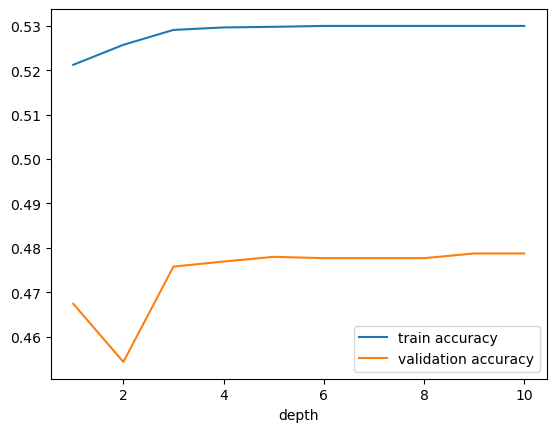

In [14]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

In [17]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
male_importances = pd.DataFrame()
male_importances['features'] = X_ohe.columns
male_importances['importances'] = importances
male_importances

,features,importances
0,Division_I,0.394440
1,Division_II,0.226486
2,Division_III,0.145244
3,Season_19_20,0.064842
4,Season_20_21,0.023364
5,Season_21_22,0.013735
6,Season_22_23,0.012811
7,Season_23_24,0.119077


## Female

In [18]:
comparing_female= df[df["Gender"] == "F"].pivot_table(values='Points', index='ID', columns='isHS', aggfunc='max')
comparing_female.head(8)

isHS,False,True
ID,,
19185,703.308104,1040.840801
31849,587.552232,598.562896
74887,640.592607,740.663716
75074,708.749168,756.584905
76046,686.261498,486.355765
85496,625.124677,521.204067
86027,319.330589,761.369664
86833,525.516203,470.131466


In [19]:
comparing_female['Difference'] = comparing_female[False] - comparing_female[True]
comparing_female['Difference'] = comparing_female['Difference'].replace([float('inf'), -float('inf')], float('nan'))
comparing_female = comparing_female.dropna(subset=['Difference'])
comparing_female = comparing_female.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
comparing_female

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
19185,703.308104,1040.840801,-337.532697
31849,587.552232,598.562896,-11.010664
74887,640.592607,740.663716,-100.071109
75074,708.749168,756.584905,-47.835737
76046,686.261498,486.355765,199.905733
...,...,...,...
2911878,341.941359,217.213786,124.727572
2914053,672.361402,600.858163,71.503239
3008853,542.245286,265.838311,276.406975


In [20]:
female = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  comparing_female, 
                  on=['ID'], 
                  how='left')
female = female.dropna()
female['Rating'] = pd.cut(female['Difference'], [-1000, 16, 1000], labels = ['bad', 'good'])
female['Rating'].value_counts()

Rating
good    103483
bad      99535
Name: count, dtype: int64

In [30]:
X = female[['Division', 'Season']]
# one hot encoding
X_ohe = pd.get_dummies(X).astype('int')
X_ohe

,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
3315,1,0,0,0,1,0,0,0,0,0
3316,1,0,0,0,1,0,0,0,0,0
3317,1,0,0,0,1,0,0,0,0,0
3318,1,0,0,0,1,0,0,0,0,0
3319,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
354318,0,0,0,1,0,0,0,0,0,1
354319,0,0,0,1,0,0,0,0,0,1
354320,0,0,0,1,0,0,0,0,0,1
354321,0,0,0,1,0,0,0,0,0,1


In [31]:
X_ohe = X_ohe.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [32]:
y = female['Rating']

### Decision Tree with CV

In [43]:
dtree = DecisionTreeClassifier(max_depth = 10)
parameters = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtreeCV = GridSearchCV(dtree, 
                       param_grid = parameters, 
                       return_train_score = True,
                       n_jobs = -1)
dtreeCV.fit(X_ohe, y)

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=10), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [44]:
dtreeCV.best_params_

{'max_depth': 1}

In [45]:
accuracy = dtreeCV.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.5177866002029377


In [46]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.519907,0.486139
1,2,0.534270,0.464806
2,3,0.537515,0.466230
3,4,0.537628,0.466230
4,5,0.537632,0.466230
5,6,0.537632,0.466230
6,7,0.537940,0.460674
7,8,0.537940,0.460674
8,9,0.537940,0.460674
9,10,0.537940,0.460674


<Axes: xlabel='depth'>

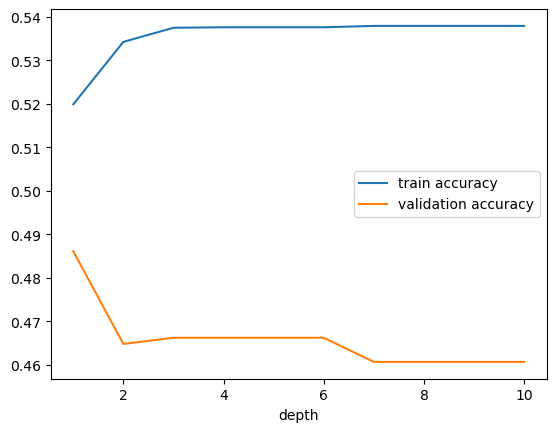

In [47]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

In [48]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
female_importances = pd.DataFrame()
female_importances['features'] = X_ohe.columns
female_importances['importances'] = importances
female_importances

,features,importances
0,Division_I,1.0
1,Division_II,0.0
2,Division_III,0.0
3,Season_19_20,0.0
4,Season_20_21,0.0
5,Season_21_22,0.0
6,Season_22_23,0.0
7,Season_23_24,0.0


In [52]:
### Decision Tree at fixed depth

In [53]:
dtree1 = DecisionTreeClassifier(max_depth=10)
dtree1.fit(X_ohe, y)

DecisionTreeClassifier(max_depth=10)

In [54]:
accuracy = dtree1.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.5301648129722487


In [55]:
dtree_string = export_text(dtree1, feature_names=list(X_ohe.columns), decimals=1, spacing=5)
print(dtree_string)

|----- Division_I <= 0.5
|     |----- Division_II <= 0.5
|     |     |----- Season_19_20 <= 0.5
|     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |----- Season_23_24 <= 0.5
|     |     |     |     |     |----- Season_22_23 <= 0.5
|     |     |     |     |     |     |----- Season_21_22 <= 0.5
|     |     |     |     |     |     |     |----- class: bad
|     |     |     |     |     |     |----- Season_21_22 >  0.5
|     |     |     |     |     |     |     |----- class: bad
|     |     |     |     |     |----- Season_22_23 >  0.5
|     |     |     |     |     |     |----- class: bad
|     |     |     |     |----- Season_23_24 >  0.5
|     |     |     |     |     |----- class: bad
|     |     |     |----- Season_20_21 >  0.5
|     |     |     |     |----- class: good
|     |     |----- Season_19_20 >  0.5
|     |     |     |----- class: good
|     |----- Division_II >  0.5
|     |     |----- Season_19_20 <= 0.5
|     |     |     |----- Season_23_24 <= 0.5
|     |     |  

In [59]:
importances = dtree1.feature_importances_
female_importances = pd.DataFrame()
female_importances['Features'] = X_ohe.columns
female_importances['importances'] = importances
female_importances.sort_values('importances', ascending=False)

,Features,importances
0,Division_I,0.489089
1,Division_II,0.451386
5,Season_21_22,0.017276
3,Season_19_20,0.014382
7,Season_23_24,0.013142
4,Season_20_21,0.010814
6,Season_22_23,0.003910
2,Division_III,0.000000


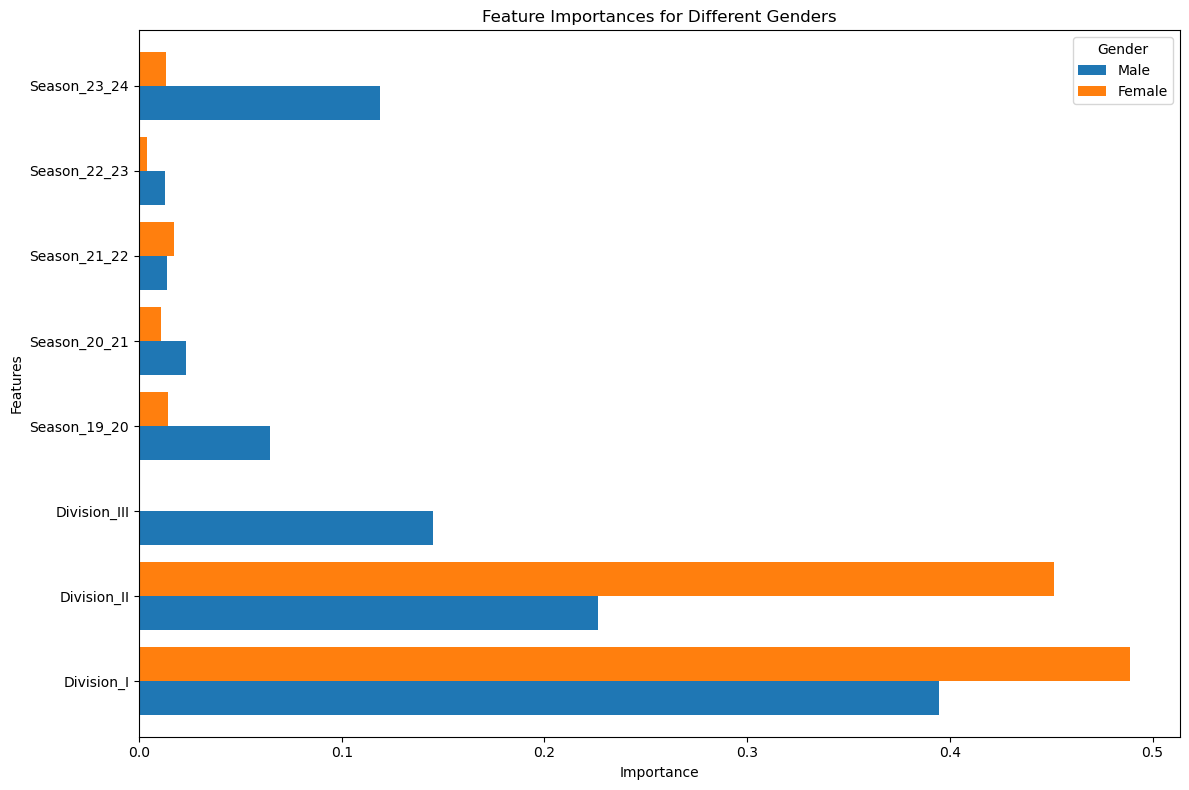

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure feature importances are stored correctly
male_importances_df = pd.DataFrame({
    'Features': X_ohe.columns,
    'Male': male_importances['importances'].values  # Extract column values
})

female_importances_df = pd.DataFrame({
    'Features': X_ohe.columns,
    'Female': female_importances['importances'].values  # Extract column values
})

# Merge them into a single DataFrame
df_importances = male_importances_df.merge(female_importances_df, on='Features')

# Set the Features as the index
df_importances.set_index('Features', inplace=True)

# Plot the feature importances as a horizontal bar chart
df_importances.plot.barh(figsize=(12, 8), width=0.8)

plt.title('Feature Importances for Different Genders')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.legend(title='Gender', loc='best')
plt.tight_layout()
plt.show()
